In [1]:
import cv2
import numpy as np 
from glob import glob
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

### Classes

In [139]:
class ImageHelpers:
    def __init__(self):
        self.sift_object = cv2.xfeatures2d.SIFT_create()

    def gray(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        return gray

    def features(self, image):
        keypoints, descriptors = self.sift_object.detectAndCompute(image, None)
        return [keypoints, descriptors]


class BOVHelpers:
    def __init__(self, n_clusters=20):
        self.n_clusters = n_clusters
        self.kmeans_obj = KMeans(n_clusters=n_clusters)
        self.kmeans_ret = None
        self.descriptor_vstack = None
        self.mega_histogram = None
        self.clf = SVC()

    def cluster(self):
        """
        cluster using KMeans algorithm,

        """
        self.kmeans_ret = self.kmeans_obj.fit_predict(self.descriptor_vstack)

    def developVocabulary(self, n_images, descriptor_list, kmeans_ret=None):
        """
        Each cluster denotes a particular visual word
        Every image can be represeted as a combination of multiple
        visual words. The best method is to generate a sparse histogram
        that contains the frequency of occurence of each visual word

        Thus the vocabulary comprises of a set of histograms of encompassing
        all descriptions for all images

        """

        self.mega_histogram = np.array(
            [np.zeros(self.n_clusters) for i in range(n_images)])
        old_count = 0
        for i in range(n_images):
            l = len(descriptor_list[i])
            for j in range(l):
                if kmeans_ret is None:
                    idx = self.kmeans_ret[old_count+j]
                else:
                    idx = self.kmeans_ret[old_count+j]
                self.mega_histogram[i][idx] += 1
            old_count += l
        print("Vocabulary Histogram Generated")

    def standardize(self, std=None):
        """

        standardize is required to normalize the distribution
        wrt sample size and features. If not normalized, the classifier may become
        biased due to steep variances.

        """
        if std is None:
            self.scale = StandardScaler().fit(self.mega_histogram)
            self.mega_histogram = self.scale.transform(self.mega_histogram)
        else:
            print("STD not none. External STD supplied")
            self.mega_histogram = std.transform(self.mega_histogram)

    def formatND(self, l):
        """
        restructures list into vstack array of shape
        M samples x N features for sklearn

        """
        vStack = np.array(l[0])
        for remaining in l[1:]:
            vStack = np.vstack((vStack, remaining))
        self.descriptor_vstack = vStack.copy()
        return vStack

    def train(self, train_labels):
        """
        uses sklearn.svm.SVC classifier (SVM)


        """
        print("Training SVM")
        print(self.clf)
        print("Train labels", train_labels)
        self.clf.fit(self.mega_histogram, train_labels)
        print("Training completed")

    def predict(self, iplist):
        predictions = self.clf.predict(iplist)
        return predictions

    def plotHist(self, vocabulary=None):
        print("Plotting histogram")
        if vocabulary is None:
            vocabulary = self.mega_histogram

        x_scalar = np.arange(self.n_clusters)
        y_scalar = np.array([abs(np.sum(vocabulary[:, h], dtype=np.int32))
                             for h in range(self.n_clusters)])

#         print(y_scalar)

        plt.bar(x_scalar, y_scalar)
        plt.xlabel("Visual Word Index")
        plt.ylabel("Frequency")
        plt.title("Complete Vocabulary Generated")
        plt.xticks(x_scalar + 0.4, x_scalar)
        plt.show()

    def buildImageHistogram(self, descriptors, kmeans_ret=None):
        
        print("Generating histogram for image")
        histogram = np.zeros(len(self.kmeans_obj.cluster_centers_))

        cluster_result =  self.kmeans_obj.predict(descriptors)
        for i in cluster_result:
            histogram[i] += 1.0
        
        x_scalar = np.arange(self.n_clusters)
        y_scalar = np.array([abs(np.sum(histogram[h], dtype=np.int32))
                             for h in range(self.n_clusters)])
#         print(y_scalar)

        plt.bar(x_scalar, y_scalar)
        plt.xlabel("Visual Word Index")
        plt.ylabel("Frequency")
        plt.title("Histogram for a specific image")
        plt.xticks(x_scalar + 0.4, x_scalar)
        plt.show()


class FileHelpers:

    def __init__(self):
        pass

    def getFiles(self, path):
        """
        - returns  a dictionary of all files 
        having key => value as  objectname => image path
        - returns total number of files.
        """
        imlist = {}
        count = 0
        for each in glob(path + "*"):
            word = each.split("/")[-1]
            imlist[word] = []
            for imagefile in glob(path+word+"/*/*.jpg"):
                im = cv2.imread(imagefile, 0)
                imlist[word].append(im)
                count += 1

        return [imlist, count]

### Bag of Visual Words

In [136]:
class BOV:
    def __init__(self, no_clusters):
        self.no_clusters = no_clusters
        self.train_path = None
        self.test_path = None
        self.im_helper = ImageHelpers()
        self.bov_helper = BOVHelpers(no_clusters)
        self.file_helper = FileHelpers()
        self.images = None
        self.trainImageCount = 0
        self.train_labels = np.array([])
        self.name_dict = {}
        self.descriptor_list = []

    def trainModel(self):
        """
        This method contains the entire module 
        required for training the bag of visual words model

        Use of helper functions will be extensive.

        """

        # read file. prepare file lists.
        self.images, self.trainImageCount = self.file_helper.getFiles(
            self.train_path)
        # extract SIFT Features from each image
        label_count = 0
        for word, imlist in self.images.items():
            self.name_dict[str(label_count)] = word
            print("Computing Features for ", word)
            for im in imlist:
                self.train_labels = np.append(self.train_labels, label_count)
                kp, des = self.im_helper.features(im)
                self.descriptor_list.append(des)

            label_count += 1
        
        
        # perform clustering
        print("Performing clustering")
        bov_descriptor_stack = self.bov_helper.formatND(self.descriptor_list)
        self.bov_helper.cluster()
        
        print("Developing vocabulary")
        self.bov_helper.developVocabulary(
            n_images=self.trainImageCount, descriptor_list=self.descriptor_list)

        self.bov_helper.standardize()

        self.bov_helper.plotHist()

        self.bov_helper.buildImageHistogram(self.descriptor_list[2])
        
        self.bov_helper.buildImageHistogram(self.descriptor_list[11])
        
        self.bov_helper.buildImageHistogram(self.descriptor_list[35])

        # self.bov_helper.train(self.train_labels)

    def recognize(self, test_img, test_image_path=None):
        """ 
        This method recognizes a single image 
        It can be utilized individually as well.


        """

        kp, des = self.im_helper.features(test_img)
        # print kp
        print(des.shape)

        # generate vocab for test image
        vocab = np.array([[0 for i in range(self.no_clusters)]])
        # locate nearest clusters for each of
        # the visual word (feature) present in the image

        # test_ret =<> return of kmeans nearest clusters for N features
        test_ret = self.bov_helper.kmeans_obj.predict(des)
        # print test_ret

        # print vocab
        for each in test_ret:
            vocab[0][each] += 1

        print(vocab)
        # Scale the features
        vocab = self.bov_helper.scale.transform(vocab)

        # predict the class of the image
        lb = self.bov_helper.clf.predict(vocab)
        # print "Image belongs to class : ", self.name_dict[str(int(lb[0]))]
        return lb

    def testModel(self):
        """ 
        This method is to test the trained classifier

        read all images from testing path 
        use BOVHelpers.predict() function to obtain classes of each image

        """

        self.testImages, self.testImageCount = self.file_helper.getFiles(
            self.test_path)

        predictions = []

        for word, imlist in self.testImages.items():
            print("processing ", word)
            for im in imlist:
                # print imlist[0].shape, imlist[1].shape
                print(im.shape)
                cl = self.recognize(im)
                print(cl)
                predictions.append({
                    'image': im,
                    'class': cl,
                    'object_name': self.name_dict[str(int(cl[0]))]
                })

        print(predictions)
        for each in predictions:
            # cv2.imshow(each['object_name'], each['image'])
            # cv2.waitKey()
            # cv2.destroyWindow(each['object_name'])
            #
            plt.imshow(cv2.cvtColor(each['image'], cv2.COLOR_GRAY2RGB))
            plt.title(each['object_name'])
            plt.show()

    def print_vars(self):
        pass

Computing Features for  3
Computing Features for  0
Performing clustering
Developing vocabulary
Vocabulary Histogram Generated
Plotting histogram


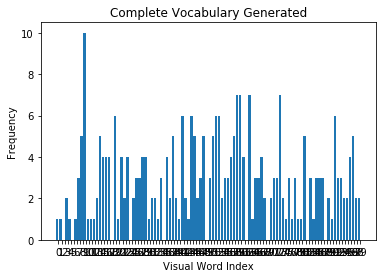

Generating histogram for image


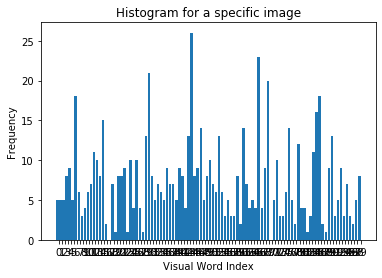

Generating histogram for image


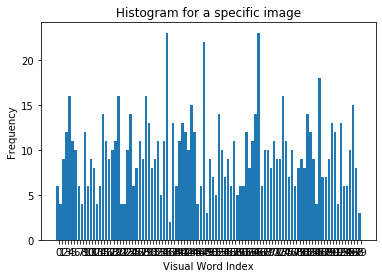

Generating histogram for image


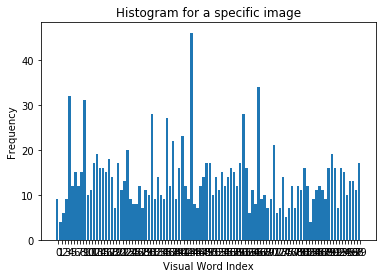

In [140]:
bov = BOV(no_clusters=100)

# set training paths
bov.train_path = "/home/fabiana/Desktop/projeto-final-src/datasets/SmallTest/"

# set testing paths
# bov.test_path = args['test_path']

# train the model
bov.trainModel()